# Reinforcement Learning Offline

### Phase 0: Import libraries and read data

In [24]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
import d3rlpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from tqdm import tqdm
sns.set_theme()

In [25]:
states=['HH TPH',
 'min_sag power index_5',
 'min_solid percentage_5',
 #'min_speed_10',
 'max_granulometry_5',
 #'var_speed_10',
 #'max_speed_10',
 #'min_delta HH charge cell_10',
 #'max_delta HH charge cell_10',
 'min_HH charge cell_5',
 #'var_sag power index_3',
 #'Edad',
 'var_solid percentage_5',
 #'var_charge cell_5',
 #'var_sag power index_5',
 #'var_charge cell_5',
 #'var_solid percentage_5',
 'var_granulometry_5',
 #'var_solid percentage_5',
 #'var_sag power index_10',
 #'var_charge cell_5',
 #'charge cell',
 #'var_granulometry_10',########
 #'var_speed_3',
 #"water",
 "Edad_0.0",	
 "Edad_1.0",
"Edad_2.0"
 ]

states=[
 'charge cell',
 #'water',
 'speed',
 'HH TPH',
 'granulometry',
 'solid percentage',
 'min_HH charge cell_5',

 "Edad_0.0",	
 "Edad_1.0",
"Edad_2.0"
 ]

actions=[
    'HH charge cell'
    ]

reward=[
    "loss of TPH"
    ]

In [26]:
df_events = pd.read_csv("../../data/processed data/events_08September2023.csv")
df_events.head(1)

,inicio perdida,fin perdida,inicio evento,fin evento,impacto TPH,variación HH TPH,std HH TPH,Causalidad sistema de control,Causalidad molino vacio,Tipo de evento,Flag,duración evento
0,2018-01-01 00:51:00,2018-01-01 01:30:00,2018-01-01 00:41:00,2018-01-01 01:40:00,6.131858,False,0.0,False,False,Embancamiento,E,39.0


In [27]:
# Consideramos solo eventos de embancamiento para el entrenamiento del agente
df_events_train=df_events[(df_events["Flag"]=="E")]
df_events_train.head(1)

,inicio perdida,fin perdida,inicio evento,fin evento,impacto TPH,variación HH TPH,std HH TPH,Causalidad sistema de control,Causalidad molino vacio,Tipo de evento,Flag,duración evento
0,2018-01-01 00:51:00,2018-01-01 01:30:00,2018-01-01 00:41:00,2018-01-01 01:40:00,6.131858,False,0.0,False,False,Embancamiento,E,39.0


In [28]:
df=pd.read_csv("../../data/processed data/feature_engineering_event_to_train_24September2023.csv",parse_dates=['Timestamp'], index_col='Timestamp').drop(["Unnamed: 0"],axis=1)
df["Edad"]=df["Edad"].astype("category")
df["loss of TPH"]=df["delta HH TPH"].apply(lambda x: -10 if x>100 else 1)
df.head(1)

,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,loss of TPH,...,sag power index_(t-2),sag power index_(t-3),sag power index_(t-4),sag power index_(t-5),Edad_(t-1),Edad_(t-2),Edad_(t-3),Edad_(t-4),Edad_(t-5),terminals
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:41:00,62.194272,879.743593,9.250324,72.353758,1682.915344,4352.8471,4350.0,820.0,900.0,1,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0


In [29]:
# Aplicar one-hot encoding a la columna 'Edad'
df=pd.get_dummies(df, columns=['Edad'])

In [30]:
df["loss of TPH"].value_counts()

-10    156045
 1     121243
Name: loss of TPH, dtype: int64

### Phase 1: Split data train/test & processing

In [31]:
# Entrenamiento
entrenamiento=pd.concat([df["2020-01":"2020-05"],df["2020-07":"2020-12"],df["2021-01":"2021-08"],df["2021-10":"2021-12"]])
entrenamiento=entrenamiento[entrenamiento["HH charge cell"]<950]
Ytrain=entrenamiento[["loss of TPH","terminals"]]
Xtrain=entrenamiento.drop(columns=["loss of TPH","terminals"])
print(Ytrain["loss of TPH"].value_counts())
print(Ytrain["terminals"].value_counts())
Xtrain.head()

-10    45825
 1     34881
Name: loss of TPH, dtype: int64
0    79213
1     1493
Name: terminals, dtype: int64


,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,start loss of TPH,...,sag power index_(t-4),sag power index_(t-5),Edad_(t-1),Edad_(t-2),Edad_(t-3),Edad_(t-4),Edad_(t-5),Edad_0.0,Edad_1.0,Edad_2.0
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-09 14:22:00,38.442361,846.685905,9.312184,67.781064,1951.832156,4106.742419,4100.0,790.0,870.0,0,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0,1,0
2020-01-09 14:23:00,38.460617,842.296852,9.311557,67.875273,1955.698954,4136.553286,4100.0,790.0,870.0,0,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0,1,0
2020-01-09 14:24:00,38.420183,838.129304,9.313310,67.578678,1928.000205,4021.548683,4100.0,790.0,870.0,0,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0,1,0
2020-01-09 14:25:00,38.316664,834.689811,9.311375,67.868407,1922.174629,4070.908574,4100.0,790.0,870.0,0,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0,1,0
2020-01-09 14:26:00,38.217893,833.986104,9.250037,68.250478,1877.314003,4043.418297,4100.0,790.0,870.0,0,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0,1,0


In [32]:
# Test#
test=pd.concat([df["2020-06"],df["2021-09"]])
Ytest=test[["loss of TPH","terminals"]]
Xtest=test.drop(columns=["loss of TPH","terminals"])
print(Ytest["loss of TPH"].value_counts())
print(Ytest["terminals"].value_counts())
Xtest.head()

-10    4853
 1     2814
Name: loss of TPH, dtype: int64
0    7544
1     123
Name: terminals, dtype: int64


,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,start loss of TPH,...,sag power index_(t-4),sag power index_(t-5),Edad_(t-1),Edad_(t-2),Edad_(t-3),Edad_(t-4),Edad_(t-5),Edad_0.0,Edad_1.0,Edad_2.0
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,52.804040,811.822555,8.877953,65.044377,1892.299050,3521.435209,4400.0,740.0,820.0,0,...,183.0,183.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2020-06-01 00:01:00,53.156466,813.198992,8.879825,65.117248,1901.347785,3544.087938,4400.0,740.0,820.0,0,...,183.0,183.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2020-06-01 00:02:00,53.727042,815.053266,8.871138,65.003770,1902.865436,3537.561008,4400.0,740.0,820.0,0,...,183.0,183.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2020-06-01 00:03:00,54.287458,814.545495,8.868254,65.048301,1906.797769,3546.380520,4400.0,740.0,820.0,0,...,183.0,183.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2020-06-01 00:04:00,54.705388,812.278098,8.872953,65.001259,1895.069348,3521.180643,4400.0,740.0,820.0,0,...,183.0,183.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [33]:
# scaler
scaler = MinMaxScaler()

In [34]:
Xtrain_0=pd.DataFrame(scaler.fit_transform(Xtrain[states+actions]),columns=states+actions,index=Xtrain.index)
Xtrain_0.head()

,charge cell,speed,HH TPH,granulometry,solid percentage,min_HH charge cell_5,Edad_0.0,Edad_1.0,Edad_2.0,HH charge cell
Timestamp,,,,,,,,,,
2020-01-09 14:22:00,0.678259,0.994738,0.633333,0.220000,0.292839,0.716981,0.0,1.0,0.0,0.716981
2020-01-09 14:23:00,0.668225,0.994666,0.633333,0.220245,0.297617,0.716981,0.0,1.0,0.0,0.716981
2020-01-09 14:24:00,0.658697,0.994868,0.633333,0.219701,0.282572,0.716981,0.0,1.0,0.0,0.716981
2020-01-09 14:25:00,0.650833,0.994645,0.633333,0.218309,0.297269,0.716981,0.0,1.0,0.0,0.716981
2020-01-09 14:26:00,0.649224,0.987574,0.633333,0.216980,0.316651,0.716981,0.0,1.0,0.0,0.716981


In [35]:
Xtest_0=pd.DataFrame(scaler.transform(Xtest[states+actions]),columns=states+actions,index=Xtest.index)
Xtest_0.head()

,charge cell,speed,HH TPH,granulometry,solid percentage,min_HH charge cell_5,Edad_0.0,Edad_1.0,Edad_2.0,HH charge cell
Timestamp,,,,,,,,,,
2020-06-01 00:00:00,0.598553,0.944683,0.833333,0.413230,0.154014,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:01:00,0.601700,0.944899,0.833333,0.417971,0.157711,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:02:00,0.605939,0.943897,0.833333,0.425648,0.151954,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:03:00,0.604778,0.943565,0.833333,0.433188,0.154213,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:04:00,0.599594,0.944107,0.833333,0.438811,0.151827,0.528302,1.0,0.0,0.0,0.528302


In [36]:
df_mdp_train=pd.DataFrame()
# Desfase de x minutos para considerar el estado del molino 5 minutos antes de tomar la decisión
desfase=5
df_mdp_train[states]=Xtrain_0[states].shift(desfase)
df_mdp_train["HH charge cell"]=Xtrain_0[actions]
df_mdp_train[["loss of TPH","terminals"]]=Ytrain[["loss of TPH","terminals"]]
df_mdp_train.dropna(inplace=True)
print(df_mdp_train.shape)
df_mdp_train.head()

(80701, 12)


,charge cell,speed,HH TPH,granulometry,solid percentage,min_HH charge cell_5,Edad_0.0,Edad_1.0,Edad_2.0,HH charge cell,loss of TPH,terminals
Timestamp,,,,,,,,,,,,
2020-01-09 14:27:00,0.678259,0.994738,0.633333,0.220000,0.292839,0.716981,0.0,1.0,0.0,0.716981,1,0
2020-01-09 14:28:00,0.668225,0.994666,0.633333,0.220245,0.297617,0.716981,0.0,1.0,0.0,0.716981,1,0
2020-01-09 14:29:00,0.658697,0.994868,0.633333,0.219701,0.282572,0.716981,0.0,1.0,0.0,0.716981,1,0
2020-01-09 14:30:00,0.650833,0.994645,0.633333,0.218309,0.297269,0.716981,0.0,1.0,0.0,0.716981,1,0
2020-01-09 14:31:00,0.649224,0.987574,0.633333,0.216980,0.316651,0.716981,0.0,1.0,0.0,0.716981,1,0


In [37]:
observations_train=df_mdp_train[states].to_numpy()
actions_train=df_mdp_train["HH charge cell"].to_numpy().reshape(-1,1)
rewards_train=df_mdp_train[reward].to_numpy().squeeze()
terminals_train=df_mdp_train["terminals"].to_numpy()

dataset_train = d3rlpy.dataset.MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=terminals_train,
)

In [38]:
df_mdp_test=pd.DataFrame()
df_mdp_test[states]=Xtest_0[states]
df_mdp_test["HH charge cell"]=Xtest_0[actions]
df_mdp_test.dropna(inplace=True)
print(df_mdp_test.shape)
df_mdp_test.head()

(7667, 10)


,charge cell,speed,HH TPH,granulometry,solid percentage,min_HH charge cell_5,Edad_0.0,Edad_1.0,Edad_2.0,HH charge cell
Timestamp,,,,,,,,,,
2020-06-01 00:00:00,0.598553,0.944683,0.833333,0.413230,0.154014,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:01:00,0.601700,0.944899,0.833333,0.417971,0.157711,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:02:00,0.605939,0.943897,0.833333,0.425648,0.151954,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:03:00,0.604778,0.943565,0.833333,0.433188,0.154213,0.528302,1.0,0.0,0.0,0.528302
2020-06-01 00:04:00,0.599594,0.944107,0.833333,0.438811,0.151827,0.528302,1.0,0.0,0.0,0.528302


### Phase 2: Model train

In [39]:
# episode-wise split
train_episodes, test_episodes = train_test_split(dataset_train.episodes)

# setup metrics
metrics = {
  "soft_opc": d3rlpy.metrics.scorer.soft_opc_scorer(return_threshold=180),
  "initial_value": d3rlpy.metrics.scorer.initial_state_value_estimation_scorer,
}

awac = d3rlpy.algos.AWAC()

# start training with episode-wise splits
data_train=awac.fit(
    train_episodes,
    n_epochs=10,
    scorers=metrics,
    eval_episodes=test_episodes,
)

2023-09-27 23:30.08 [debug    ] RoundIterator is selected.
2023-09-27 23:30.08 [info     ] Directory is created at d3rlpy_logs\AWAC_20230927233008
2023-09-27 23:30.08 [debug    ] Building models...
2023-09-27 23:30.08 [debug    ] Models have been built.
2023-09-27 23:30.08 [info     ] Parameters are saved to d3rlpy_logs\AWAC_20230927233008\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False}, 'batch_size': 1024, 'critic_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'gamma': 0.99, 'generated_maxle

Epoch 1/10: 100%|██████████| 56/56 [00:05<00:00,  9.81it/s, critic_loss=90.4, actor_loss=26.1, mean_std=0.0502]


2023-09-27 23:30.15 [info     ] AWAC_20230927233008: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 0.0028697592871529715, 'time_algorithm_update': 0.09761900135449, 'critic_loss': 88.07003777367729, 'actor_loss': 24.596941147531783, 'mean_std': 0.05017609342134425, 'time_step': 0.10084128379821777, 'soft_opc': nan, 'initial_value': -4.516852378845215} step=56
2023-09-27 23:30.15 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_56.pt


Epoch 2/10: 100%|██████████| 56/56 [00:05<00:00,  9.89it/s, critic_loss=60.3, actor_loss=6.11, mean_std=0.0506]


2023-09-27 23:30.22 [info     ] AWAC_20230927233008: epoch=2 step=112 epoch=2 metrics={'time_sample_batch': 0.0027586562292916434, 'time_algorithm_update': 0.09789542640958514, 'critic_loss': 60.31186274119786, 'actor_loss': 5.963882403714316, 'mean_std': 0.050590832850762775, 'time_step': 0.1007044357912881, 'soft_opc': nan, 'initial_value': -6.269898891448975} step=112
2023-09-27 23:30.22 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_112.pt


Epoch 3/10: 100%|██████████| 56/56 [00:05<00:00,  9.95it/s, critic_loss=59.8, actor_loss=3.97, mean_std=0.0509]


2023-09-27 23:30.29 [info     ] AWAC_20230927233008: epoch=3 step=168 epoch=3 metrics={'time_sample_batch': 0.0023700807775769916, 'time_algorithm_update': 0.0972403883934021, 'critic_loss': 59.7889837537493, 'actor_loss': 3.907233510698591, 'mean_std': 0.05090485120724354, 'time_step': 0.09986237117222377, 'soft_opc': nan, 'initial_value': -7.196059703826904} step=168
2023-09-27 23:30.29 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_168.pt


Epoch 4/10: 100%|██████████| 56/56 [00:05<00:00,  9.88it/s, critic_loss=59.6, actor_loss=3.32, mean_std=0.0512]


2023-09-27 23:30.36 [info     ] AWAC_20230927233008: epoch=4 step=224 epoch=4 metrics={'time_sample_batch': 0.002982429095676967, 'time_algorithm_update': 0.09737850938524518, 'critic_loss': 59.61100448880877, 'actor_loss': 3.442433761698859, 'mean_std': 0.05122040817514062, 'time_step': 0.10049528309277125, 'soft_opc': nan, 'initial_value': -8.140875816345215} step=224
2023-09-27 23:30.36 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_224.pt


Epoch 5/10: 100%|██████████| 56/56 [00:05<00:00,  9.87it/s, critic_loss=59.6, actor_loss=3.16, mean_std=0.0516]


2023-09-27 23:30.43 [info     ] AWAC_20230927233008: epoch=5 step=280 epoch=5 metrics={'time_sample_batch': 0.0027644761971064974, 'time_algorithm_update': 0.09818168197359357, 'critic_loss': 59.60737228393555, 'actor_loss': 3.1265610115868703, 'mean_std': 0.05157276176448379, 'time_step': 0.10100878987993513, 'soft_opc': nan, 'initial_value': -9.079195976257324} step=280
2023-09-27 23:30.43 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_280.pt


Epoch 6/10: 100%|██████████| 56/56 [00:05<00:00,  9.80it/s, critic_loss=59.6, actor_loss=2.97, mean_std=0.0519]


2023-09-27 23:30.50 [info     ] AWAC_20230927233008: epoch=6 step=336 epoch=6 metrics={'time_sample_batch': 0.004361199481146676, 'time_algorithm_update': 0.0970780977181026, 'critic_loss': 59.6934176172529, 'actor_loss': 2.948544668299811, 'mean_std': 0.051945419649460485, 'time_step': 0.10147493651935033, 'soft_opc': nan, 'initial_value': -9.790498733520508} step=336
2023-09-27 23:30.50 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_336.pt


Epoch 7/10: 100%|██████████| 56/56 [00:05<00:00,  9.57it/s, critic_loss=59.8, actor_loss=2.81, mean_std=0.0523]


2023-09-27 23:30.57 [info     ] AWAC_20230927233008: epoch=7 step=392 epoch=7 metrics={'time_sample_batch': 0.002282896212169102, 'time_algorithm_update': 0.10067483357020787, 'critic_loss': 59.822517667497905, 'actor_loss': 2.779728033712932, 'mean_std': 0.05234198811064873, 'time_step': 0.1033048118863787, 'soft_opc': nan, 'initial_value': -10.887828826904297} step=392
2023-09-27 23:30.57 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_392.pt


Epoch 8/10: 100%|██████████| 56/56 [00:05<00:00,  9.45it/s, critic_loss=59.9, actor_loss=2.67, mean_std=0.0527]


2023-09-27 23:31.05 [info     ] AWAC_20230927233008: epoch=8 step=448 epoch=8 metrics={'time_sample_batch': 0.0033654868602752686, 'time_algorithm_update': 0.10172898854528155, 'critic_loss': 59.98261540276663, 'actor_loss': 2.6436859326703206, 'mean_std': 0.05276900430076888, 'time_step': 0.10537948778697423, 'soft_opc': nan, 'initial_value': -11.642630577087402} step=448
2023-09-27 23:31.05 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_448.pt


Epoch 9/10: 100%|██████████| 56/56 [00:05<00:00,  9.53it/s, critic_loss=60.1, actor_loss=2.57, mean_std=0.0532]


2023-09-27 23:31.12 [info     ] AWAC_20230927233008: epoch=9 step=504 epoch=9 metrics={'time_sample_batch': 0.0036253418241228375, 'time_algorithm_update': 0.10015872972352165, 'critic_loss': 60.11887189320156, 'actor_loss': 2.5183817552668706, 'mean_std': 0.05321829499942916, 'time_step': 0.10398075410297938, 'soft_opc': nan, 'initial_value': -12.633735656738281} step=504
2023-09-27 23:31.12 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_504.pt


Epoch 10/10: 100%|██████████| 56/56 [00:05<00:00,  9.59it/s, critic_loss=60.5, actor_loss=2.36, mean_std=0.0537]


2023-09-27 23:31.19 [info     ] AWAC_20230927233008: epoch=10 step=560 epoch=10 metrics={'time_sample_batch': 0.0025846873010907856, 'time_algorithm_update': 0.10092048985617501, 'critic_loss': 60.48981884547642, 'actor_loss': 2.327351840479033, 'mean_std': 0.05369437299668789, 'time_step': 0.10370248556137085, 'soft_opc': nan, 'initial_value': -13.6951322555542} step=560
2023-09-27 23:31.19 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230927233008\model_560.pt


In [40]:
# save full parameters only
awac.save_model('../../models/awac.pt')


In [41]:
# load full parameters with manual setup
awac =d3rlpy.algos.AWAC()
awac.build_with_dataset(dataset_train)
awac.load_model('../../models/awac.pt')

In [42]:
# Métricas que queremos graficar
metrics_to_plot = list(data_train[0][1].keys())

# Crear un gráfico de líneas para cada métr
for metric in metrics_to_plot:

    if metric in [ 'critic_loss',
 'actor_loss',]:
        
        x = [entry[0] for entry in data_train]
        y = [entry[1][metric] for entry in data_train]

        dic_title={'critic_loss':"Loss Critic",'actor_loss':"Loss Actor"}
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines',
                    name='lines'))
        fig.update_layout(height=500, width=700,title=f'{dic_title[metric]}')

        #fig.update_traces(line_color="#01515F")
        fig.update_layout(yaxis=dict(tickformat=".1f"), #plot_bgcolor="white",
                          )

        fig.update_layout(title_x=0.5,
        xaxis_title="Épocas",
        yaxis_title="Loss"
    )
        fig.show()


### Phase 3: Model evaluation

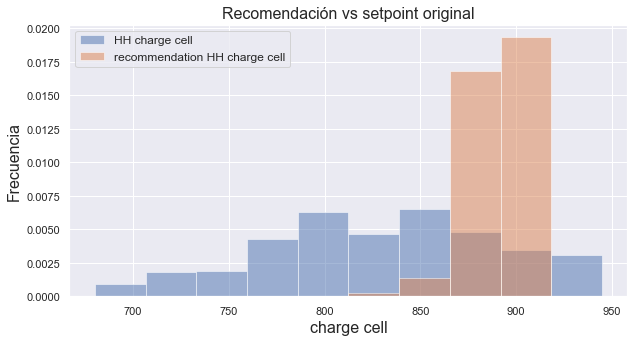

,HH charge cell,recommendation HH charge cell
count,80701.0,80701.0
mean,829.0,890.0
std,60.0,12.0
min,680.0,793.0
25%,790.0,885.0
50%,830.0,892.0
75%,880.0,899.0
max,945.0,917.0


In [43]:
#  rec HH charge cell data train
df_fin=df_mdp_train[states+actions].copy()

original_hh_charge_cell=pd.DataFrame(scaler.inverse_transform(df_fin[states+actions]),columns=states+actions,index=df_fin.index)["HH charge cell"].values

df_fin["HH charge cell"]=awac.predict([observations_train]).squeeze()

df_fin=pd.DataFrame(scaler.inverse_transform(df_fin),columns=df_fin.columns,index=df_fin.index).rename(columns={"HH charge cell":
                                                                                                       "recommendation HH charge cell"})

df_fin["HH charge cell"]=original_hh_charge_cell
ax=df_fin[["HH charge cell","recommendation HH charge cell"]].plot(kind="hist",figsize=(10,5),density=True,alpha=0.5)
ax.set_title("Recomendación vs setpoint original",fontsize=16)
ax.set_xlabel('charge cell', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.legend(fontsize=12)
plt.show()
df_fin[["HH charge cell","recommendation HH charge cell"]].describe().round(0)

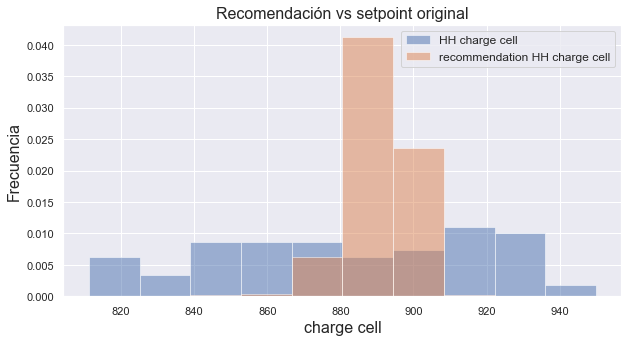

,HH charge cell,recommendation HH charge cell
count,7667.0,7667.0
mean,882.0,890.0
std,35.0,9.0
min,820.0,811.0
25%,850.0,886.0
50%,890.0,891.0
75%,910.0,897.0
max,950.0,916.0


In [44]:
#  rec HH charge cell data test
df_fin=df_mdp_test[states+actions].copy()

original_hh_charge_cell=pd.DataFrame(scaler.inverse_transform(df_fin[states+actions]),columns=states+actions,index=df_fin.index)["HH charge cell"].values

observations_test=df_fin[states].to_numpy()

df_fin["HH charge cell"]=awac.predict([observations_test]).squeeze()

df_fin=pd.DataFrame(scaler.inverse_transform(df_fin),columns=df_fin.columns,index=df_fin.index).rename(columns={"HH charge cell":
                                                                                                       "recommendation HH charge cell"})

df_fin["HH charge cell"]=original_hh_charge_cell
ax=df_fin[["HH charge cell","recommendation HH charge cell"]].plot(kind="hist",figsize=(10,5),density=True,alpha=0.5)
ax.set_title("Recomendación vs setpoint original",fontsize=16)
ax.set_xlabel('charge cell', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.legend(fontsize=12)
plt.show()
df_fin[["HH charge cell","recommendation HH charge cell"]].describe().round(0)

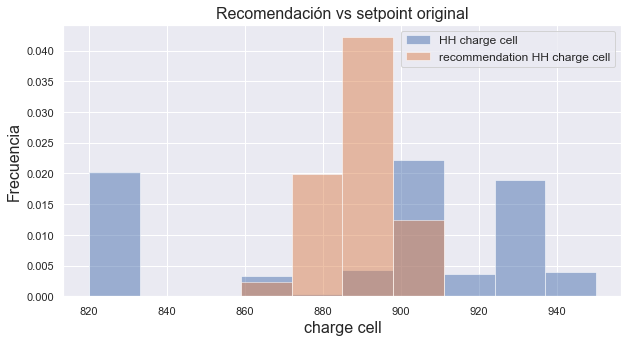

,HH charge cell,recommendation HH charge cell
count,3905.0,3905.0
mean,890.0,889.0
std,43.0,8.0
min,820.0,842.0
25%,830.0,884.0
50%,910.0,889.0
75%,930.0,895.0
max,950.0,907.0


In [51]:
# Test
test=df_mdp_test["2020-06"].copy()
original_hh_charge_cell=pd.DataFrame(scaler.inverse_transform(test[states+actions]),columns=states+actions,index=test.index)["HH charge cell"].values

observations_test=test[states].to_numpy()

test["HH charge cell"]=awac.predict([observations_test]).squeeze()

# Recomendación futura
test["HH charge cell"]=test["HH charge cell"].shift(-desfase)

df_fin=pd.DataFrame(scaler.inverse_transform(test[states+actions]),columns=states+actions,index=test.index).rename(columns={"HH charge cell":
                                                                                                       "recommendation HH charge cell"})
 
                                                                                                       
df_fin["HH charge cell"]=original_hh_charge_cell
df_fin=df_fin.join(df[["TPH",#"charge cell"
                       ]])
df_fin.dropna(inplace=True)

ax=df_fin[["HH charge cell","recommendation HH charge cell"]].plot(kind="hist",alpha=0.5,figsize=(10,5),density=True,)
ax.set_title("Recomendación vs setpoint original",fontsize=16)
ax.set_xlabel('charge cell', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.legend(fontsize=12)
plt.show()
df_fin[["HH charge cell","recommendation HH charge cell"]].describe().round(0)

In [52]:
titulos=tuple(["TPH & HH TPH", "Real charge cell setpoint & Recommendation charge cell setpoint",#"Real charge cell setpoint","Recommendation charge cell setpoint",
               ])
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=titulos,
     shared_xaxes=True, 
     vertical_spacing=0.05
    )

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['TPH'], ##FF6511
                    mode='lines',
                    name="TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH TPH'], ##FF6511
                    mode='lines',
                    name="HH TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  






#############
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['recommendation HH charge cell'], 
                    mode='lines',
                    name="recommendation HH charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH charge cell'], 
                    mode='lines',
                    name="HH charge cell",line=dict(width=3, ),legendgroup = '1',),row=2, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 



###############




#################
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=3, col=1)  




fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH charge cell'], 
                    mode='lines',
                    name="HH charge cell",line=dict(width=1, ),legendgroup = '1',showlegend=False),row=3, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH charge cell']-80, 
                    mode='lines',
                    name="LL charge cell",line=dict(width=1, ),legendgroup = '1',fill='tonexty',showlegend=False),row=3, col=1)   

#################

######
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['recommendation HH charge cell'], 
                    mode='lines',
                    name="recommendation HH charge cell",line=dict(width=1, ),legendgroup = '1',showlegend=False),row=4, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['recommendation HH charge cell']-80, 
                    mode='lines',
                    name="recommendation LL charge cell",line=dict(width=1, ),legendgroup = '1',fill='tonexty',showlegend=False),row=4, col=1) 
##############
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=4, col=1)  


fig.update_layout(height=700, width=1200, title_text="Temporal signal analysis")
fig.update_layout(hovermode="x unified")

fig.show()